In [1]:
#!/fastdata/azcopy list https://radiantearth.blob.core.windows.net/mlhub/nasa-tropical-storm-challenge

In [2]:
# use azcopy and source cooperative to download metadata bc it is not present when downloading via eotdl
# /fastdata/azcopy sync https://radiantearth.blob.core.windows.net/mlhub/nasa-tropical-storm-challenge . --recursive=false
# Code from: https://drivendata.co/blog/predict-wind-speeds-benchmark/ 

# Explore cyclone data

## Metadata

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

pd.set_option("max_colwidth", 80)

In [102]:
# This is where our downloaded images and metadata live locally
DATA_PATH = '/home/anna/.cache/eotdl/datasets/tropical-cyclone-dataset/v1'

In [5]:
train_metadata = pd.read_csv(os.path.join(DATA_PATH, "training_set_features.csv"))
train_labels = pd.read_csv(os.path.join(DATA_PATH, "training_set_labels.csv"))

In [6]:
train_metadata.head()


,Image ID,Storm ID,Relative Time,Ocean
0,nhe_000,nhe,0,2
1,nhe_001,nhe,1800,2
2,nhe_002,nhe,3600,2
3,nhe_003,nhe,5402,2
4,nhe_004,nhe,9001,2


In [7]:
train_metadata.shape

(70257, 4)

In [8]:
train_metadata['Storm ID'].nunique()

494

In [9]:
storm_counts = train_metadata.groupby("Storm ID").size()
storm_counts.describe()

count    494.000000
mean     142.220648
std      123.151772
min        4.000000
25%       46.250000
50%      101.500000
75%      209.000000
max      648.000000
dtype: float64

Text(0.5, 1.0, 'Number of Images per Storm')

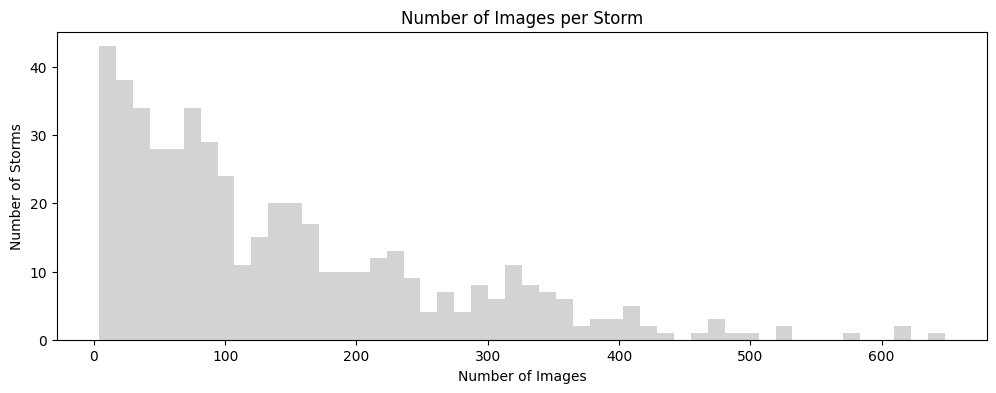

In [10]:
plt.figure(figsize=(12, 4))
plt.hist(storm_counts, bins=50, color="lightgray")
plt.xlabel("Number of Images")
plt.ylabel("Number of Storms")
plt.title("Number of Images per Storm")

In [11]:
train_metadata.groupby("Ocean")["Storm ID"].nunique()


Ocean
1    264
2    230
Name: Storm ID, dtype: int64

In [12]:
train_labels.head()

,Image ID,Wind Speed
0,nhe_000,34
1,nhe_001,34
2,nhe_002,34
3,nhe_003,33
4,nhe_004,32


In [13]:
train_labels.describe()

,Wind Speed
count,70257.000000
mean,50.344008
std,26.795277
min,15.000000
25%,30.000000
50%,43.000000
75%,62.000000
max,185.000000


Text(0.5, 1.0, 'Distribution of Wind Speeds')

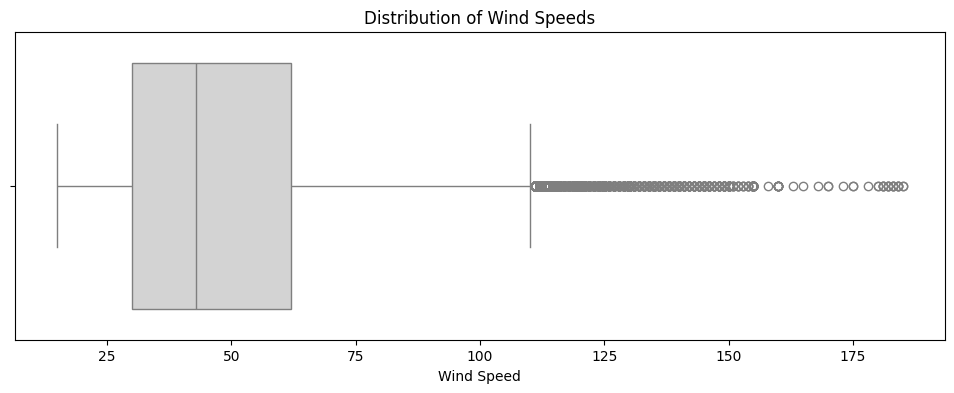

In [14]:
plt.figure(figsize=(12, 4))
sns.boxplot(x=train_labels['Wind Speed'], color="lightgray")
plt.xlabel("Wind Speed")
plt.title("Distribution of Wind Speeds")

In [15]:
# Merge train_metadata with train_labels on the image_id field
full_metadata = train_metadata.merge(train_labels, on="Image ID")


In [16]:
def plot_wind_speeds(storm_id):
    storm = full_metadata[full_metadata['Storm ID'] == storm_id]
    plt.figure(figsize=(12, 4))
    plt.scatter("Relative Time", "Wind Speed", data=storm, color="lightgray")
    plt.ticklabel_format(useOffset=False)
    plt.ylabel("Wind Speed")
    plt.title(f"Wind Speed over Relative Time: Storm {storm_id}")

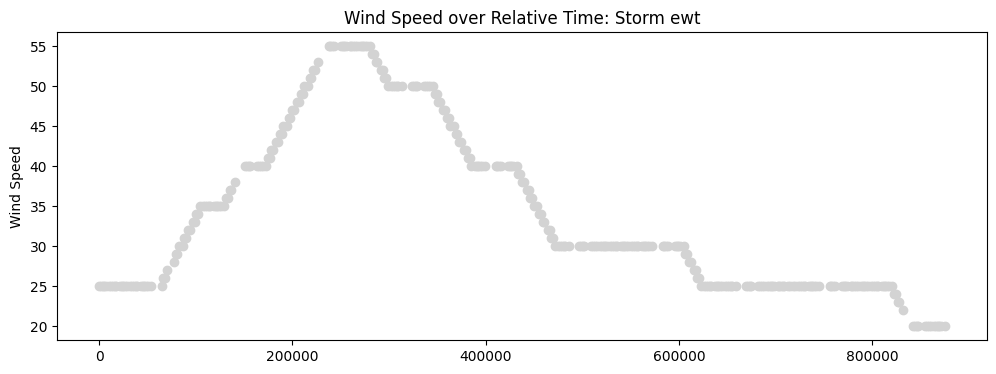

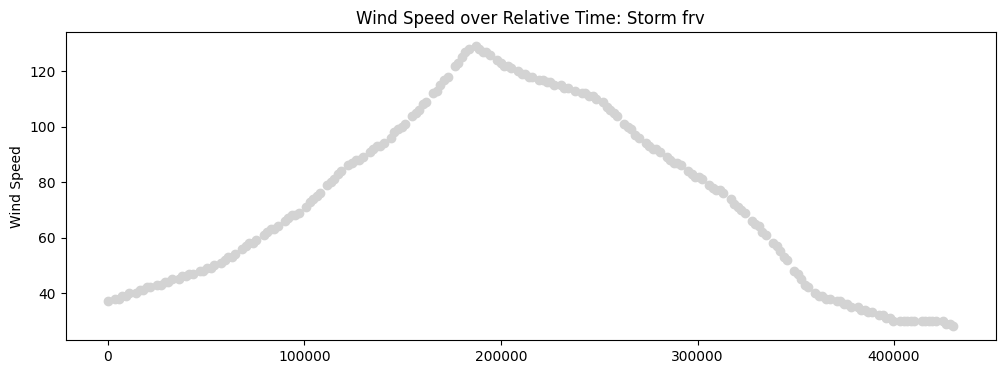

In [17]:
# Sample two random storms from full_metadata
for storm in full_metadata['Storm ID'].sample(2, random_state=40):
    plot_wind_speeds(storm)

## Images

In [18]:
# Path style access for pandas
import pandas_path

In [21]:
full_metadata.head()

,Image ID,Storm ID,Relative Time,Ocean,Wind Speed,file_name
0,nhe_000,nhe,0,2,34,/home/anna/.cache/eotdl/datasets/tropical-cyclone-dataset/v1/train/nasa_trop...
1,nhe_001,nhe,1800,2,34,/home/anna/.cache/eotdl/datasets/tropical-cyclone-dataset/v1/train/nasa_trop...
2,nhe_002,nhe,3600,2,34,/home/anna/.cache/eotdl/datasets/tropical-cyclone-dataset/v1/train/nasa_trop...
3,nhe_003,nhe,5402,2,33,/home/anna/.cache/eotdl/datasets/tropical-cyclone-dataset/v1/train/nasa_trop...
4,nhe_004,nhe,9001,2,32,/home/anna/.cache/eotdl/datasets/tropical-cyclone-dataset/v1/train/nasa_trop...


In [ ]:
# Function to create file paths for each image
DATA_PATH = Path('/home/anna/.cache/eotdl/datasets/tropical-cyclone-dataset/v1')

def create_file_path(image_id):
    return DATA_PATH / 'train' / 'nasa_tropical_storm_competition_train_source' / f'nasa_tropical_storm_competition_train_source_{image_id}' / "image.jpg"

# Apply the function to the 'Image ID' column
full_metadata["file_name"] = full_metadata["Image ID"].apply(create_file_path)

# Display the updated DataFrame
full_metadata.head('file_name')

In [22]:
from IPython.display import Image


In [23]:
def look_at_wind_speed(wind_speed):
    sample_img = full_metadata[full_metadata['Wind Speed'] == wind_speed].file_name.iloc[0]
    return Image(str(sample_img))

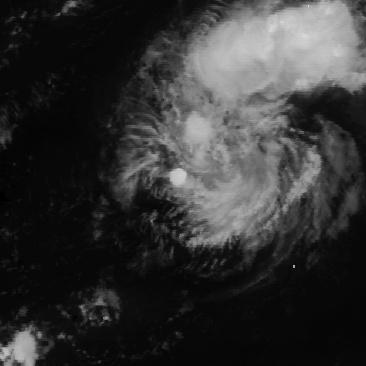

In [24]:
look_at_wind_speed(wind_speed=30)


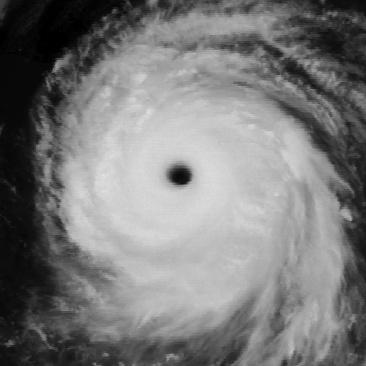

In [25]:
look_at_wind_speed(wind_speed=150)


In [26]:
from PIL import Image as pil_image
examples = [
    pil_image.open(full_metadata.iloc[i]["file_name"]).convert("RGB") for i in range(5)
]
for image in examples:
    print(image.size)

(366, 366)
(366, 366)
(366, 366)
(366, 366)
(366, 366)


# Train Model with Wrapper

In [1]:
from pytorch_eo.datasets.cyclone.tropical_cyclone import WindDataModule

hparams = {
    "lr": 2e-4,
    "embedding_dim": 100,
    "dropout": 0.1,
    "max_epochs": 4,
    "batch_size": 10,
    "num_workers": 0,
    "gradient_clip_val": 1,
    "val_sanity_checks": 0,
    "output_path": "model-outputs",
    "log_path": "logs",
}

# Data path
data_path = '/home/anna/.cache/eotdl/datasets/tropical-cyclone-dataset/v1'

# Create data module
data_module = WindDataModule(data_path=data_path, batch_size=hparams['batch_size'], num_workers=hparams['num_workers'])


In [10]:
# Create model
import torch
from pytorch_eo.datasets.cyclone.tropical_cyclone import WindModel
import pytorch_lightning as pl
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_new = WindModel(**hparams).to(device)

# Train the model
trainer = pl.Trainer(
    max_epochs=hparams['max_epochs'],
    default_root_dir=hparams['output_path'],
    logger=pl.loggers.TensorBoardLogger(save_dir=hparams['log_path'], name="benchmark_model_new"),
    callbacks=[pl.callbacks.ModelCheckpoint(
        dirpath=hparams['output_path'],
        monitor="avg_epoch_val_loss",
        mode="min",
        verbose=True,
    )],
    gradient_clip_val=hparams['gradient_clip_val'],
    num_sanity_val_steps=hparams['val_sanity_checks'],
)
trainer.fit(model_new, datamodule=data_module)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 58.3 M
---------------------------------
58.3 M    Trainable params
0       

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 564: 'avg_epoch_val_loss' reached 11.64790 (best 11.64790), saving model to '/home/anna/Desktop/pytorchEO/examples/model-outputs/epoch=0-step=564.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 1128: 'avg_epoch_val_loss' reached 9.93356 (best 9.93356), saving model to '/home/anna/Desktop/pytorchEO/examples/model-outputs/epoch=1-step=1128.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 1692: 'avg_epoch_val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 2256: 'avg_epoch_val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=4` reached.


In [12]:

# Accessing logged metrics
metrics = trainer.logged_metrics
print(metrics)


{'train_loss': tensor(8.3500), 'val_loss': tensor(10.2456), 'avg_epoch_val_loss': tensor(10.2404), 'avg_epoch_train_loss': tensor(11.5420)}


# Export to onnx

In [6]:
import torch
import torch.onnx
from torchvision import transforms
from PIL import Image
import onnx
from pytorch_eo.datasets.cyclone.tropical_cyclone import WindModel

# Assuming your model class and all necessary imports are already defined above

# Instantiate your model
hparams = {
    "lr": 2e-4,
    "embedding_dim": 100,
    "dropout": 0.1,
    "max_epochs": 4,
    "batch_size": 10,
    "num_workers": 0,
    "gradient_clip_val": 1,
    "val_sanity_checks": 0,
    "output_path": "model-outputs",
    "log_path": "logs",
}

model = WindModel(**hparams)
device = torch.device("cpu")
model.to(device)
model.eval()  # Set the model to evaluation mode

# Create a dummy input tensor
dummy_input = torch.randn(1, 3, 224, 224, device=device)  # Example input size for ResNet

# Define the path where you want to save the ONNX model
onnx_model_path = "wind_model.onnx"

# Export the model to ONNX
torch.onnx.export(
    model,
    dummy_input,
    onnx_model_path,
    export_params=True,  # Store the trained parameter weights inside the model file
    opset_version=11,  # The ONNX version to export the model to
    do_constant_folding=True,  # Whether to execute constant folding for optimization
    input_names=['input'],  # The model's input names
    output_names=['output'],  # The model's output names
    dynamic_axes={'input': {0: 'batch_size'},  # Variable length axes
                  'output': {0: 'batch_size'}}
)

print(f"Model has been successfully exported to {onnx_model_path}")




============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Model has been successfully exported to wind_model.onnx


In [7]:
# Optional: Load and check the exported model
onnx_model = onnx.load(onnx_model_path)
onnx.checker.check_model(onnx_model)
print("Model successfully checked!")

Model successfully checked!
